# PyTorch NN Module

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
# F is usually used for stateless functions.
import torch.nn.functional as F

def _print(val):
    print(val, val.shape, '\n')

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
x_train.shape

(50000, 784)

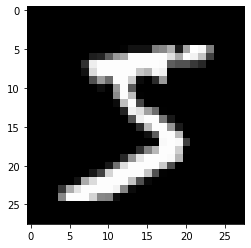

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_train[0].reshape(-1,28,28).squeeze(), cmap='gray')
plt.show()

In [7]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                       (x_train, y_train, x_valid, y_valid))
print(x_train.shape)
print(y_train, y_train.min(), y_train.max())

torch.Size([50000, 784])
tensor([5, 0, 4,  ..., 8, 4, 8]) tensor(0) tensor(9)


## Neural Nets from Scratch

### Activation log_softmax

LogSoftMax works better than regular SoftMax? [link](https://discuss.pytorch.org/t/logsoftmax-vs-softmax/21386/2)

The point is, even though logsoftmax and softmax are monotonic, their effect on the relative values of the loss function changes. Using the log-softmax will punish bigger mistakes in likelihood space higher.

In [9]:
import math

#Activation function Outputs log-probabilities
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb.mm(weights) + bias)

#Xavier Initialization
weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10)
bias.requires_grad_()

print(x_train.shape)
print(weights.shape)
print(bias.shape)

torch.Size([50000, 784])
torch.Size([784, 10])
torch.Size([10])


In [10]:
xb = x_train[:3]
yb = y_train[:3]
print("shape:",xb.shape)
print("mm Shape: ",xb.mm(weights).shape,'\n')
print(xb.mm(weights)[0],'\n')
print(xb.mm(weights)[0]+bias,'\n')
xb = xb.mm(weights)+bias
print(xb.exp().sum(-1).log().unsqueeze(-1),'\n')
print((xb - xb.exp().sum(-1).log().unsqueeze(-1))[0])
pred = xb - xb.exp().sum(-1).log().unsqueeze(-1)
print(torch.argmax(pred, 1))
print(yb)

shape: torch.Size([3, 784])
mm Shape:  torch.Size([3, 10]) 

tensor([-0.5272,  0.0963,  0.0887, -0.0125, -0.1122, -0.2317, -0.3209, -0.2690,
         0.1451,  0.1168], grad_fn=<SelectBackward>) 

tensor([-0.5272,  0.0963,  0.0887, -0.0125, -0.1122, -0.2317, -0.3209, -0.2690,
         0.1451,  0.1168], grad_fn=<AddBackward0>) 

tensor([[2.2223],
        [2.4680],
        [2.3355]], grad_fn=<UnsqueezeBackward0>) 

tensor([-2.7495, -2.1260, -2.1336, -2.2348, -2.3345, -2.4539, -2.5432, -2.4913,
        -2.0772, -2.1055], grad_fn=<SelectBackward>)
tensor([8, 1, 8])
tensor([5, 0, 4])


### Negative log loss

__Log loss__ (related to cross entropy measures performance of classification where prediction input is a prob value between 0 and 1. Perfect model should have log loss 0. 

Log loss increases as predicted prob diverges from actual label.

<img src=http://wiki.fast.ai/images/math/8/a/a/8aa1e513366a2046bee816f7a0f8dd1c.png>

Note that y=0 if incorrect class

Since the activation function was log_softmax, we do not have to take the log of the activation again. Just take the negative activation of the True class for each example

In [12]:
batch_size = 64
def nll(input, target):
    return -input[range(target.shape[0]),target].mean()

def accuracy(input, target):
    p = torch.argmax(input, dim=1)
    return (p==target).float().mean()

#yb = y_train[:batch_size]
print(accuracy(pred,yb))
print(nll(pred,yb))

tensor(0.)
tensor(2.7102, grad_fn=<NegBackward>)


In [14]:
# grab the log-prob of correct class
print(-pred[range(yb.shape[0]),yb])
#this is neg_log_loss for each example -> 
#average them for cost
print(-pred[range(yb.shape[0]),yb].mean())
#want to maximize this number -> make correct class as
#large as possible

#How does this work? seems like signs are wrong

tensor([2.4539, 3.2070, 2.4697], grad_fn=<NegBackward>)
tensor(2.7102, grad_fn=<NegBackward>)


### Training the parameters

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).



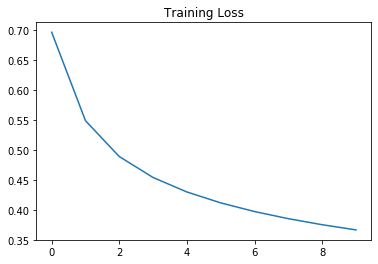

In [15]:
from IPython.core.debugger import set_trace

#Xavier Initialization
weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10)
bias.requires_grad_()


epochs = 10 # each epoch goes over the entire training set
batch_size = 64
lr = 0.01
n = x_train.shape[0]

loss_hist = []
for epoch in range(epochs):
    for i in range((n-1)//batch_size): # // ~ int division
        start = i * batch_size
        end = (i + 1) * batch_size

        xb, yb = x_train[start:end], y_train[start:end]
        pred = model(xb)
        loss = nll(pred, yb)
        loss.backward()

        with torch.no_grad(): #no_grad so we can do an in-place operation on a leaf node
            weights -= lr*weights.grad
            bias -= lr*bias.grad
            weights.grad.zero_()
            bias.grad.zero_()
    loss_hist.append(loss.data.item())

plt.title("Training Loss")
plt.plot(range(len(loss_hist)),loss_hist) 
plt.show()

In [16]:
pred = model(x_valid)
print(nll(pred, y_valid))
print(accuracy(pred, y_valid))

tensor(0.3372, grad_fn=<NegBackward>)
tensor(0.9093)


## Factoring with torch.nn
Either make your code shorter, more understandable, or more flexible.

In [18]:
import torch.nn.functional as F

#combines neg-log-likelihood loss and log-softmax
loss_func = F.cross_entropy
def model(xb):
    return xb.mm(weights)+bias

### Package the model into a Class
Use `nn.Module` and `nn.Parameter` . Create a class that holds weights and methods for forward and backward prop.

`nn.Module` class has a number of attributes and methods (such as `.parameters()` and `.zero_grad()`) which we will be using.

In [19]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        return None
        
    def forward(self, xb):
        return xb.mm(self.weights) + self.bias

### Train with model.parameters() and model.zero_grad()

In [20]:
model = Model()
for param in model.parameters():
        print(param)

Parameter containing:
tensor([[ 0.0038,  0.0605, -0.0201,  ...,  0.0187,  0.0035,  0.0011],
        [ 0.0449, -0.0991, -0.0366,  ..., -0.0118, -0.0203,  0.0033],
        [-0.0556,  0.0002, -0.0154,  ...,  0.0077,  0.0253,  0.0694],
        ...,
        [-0.0340, -0.0125,  0.0073,  ...,  0.0392,  0.0326,  0.0563],
        [-0.0217,  0.0066, -0.0273,  ..., -0.0443,  0.0208,  0.0057],
        [ 0.0183, -0.0655, -0.0350,  ...,  0.0460,  0.0087,  0.0110]],
       requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


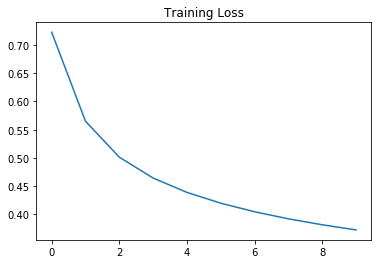

In [21]:
model = Model()
loss_func = F.cross_entropy

def fit():
    loss_hist = []
    for epoch in range(epochs):
        for i in range((n-1)//batch_size): # // ~ int division
            start = i * batch_size
            end = (i + 1) * batch_size

            xb, yb = x_train[start:end], y_train[start:end]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): #Update all weights at once
                    p -= lr*p.grad
                model.zero_grad()   #zero out gradients for all parameters
        loss_hist.append(loss.data.item())
        
    return loss_hist
    
loss_hist = fit()

plt.title("Training Loss")
plt.plot(range(len(loss_hist)),loss_hist) 
plt.show()

### With nn.Linear
[link](https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-nn-linear)
Instead of `self.bias = nn.Parameter(torch.zeros(10))` instantiate with `nn.Linear`.

In [22]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)  #no need to initialize weights
    def forward(self, xb):
        return self.lin(xb)

### With optim
instead of `p -= p.grad * lr`, use `torch.optim` to calculate an optimal step for rach batch.

In [23]:
from torch import optim

epochs = 10
bs = 64
lr = 0.01

model = Model()
loss_func = F.cross_entropy
#choose the right optimizer, SQG ~ fixed steps
opt = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        #update parameters automatically based on gradients
        opt.step()  
        opt.zero_grad()

### With Dataset

PyTorch’s `TensorDataset` is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [24]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train) #smoosh that data together
model = Model()
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs] #iterate in one line
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

### With DataLoader

In [25]:
from torch.utils.data import DataLoader
model = Model()
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr=lr)
#####################################################

train_ds = TensorDataset(x_train, y_train)
#automatic iterator over Dataset object
train_dl = DataLoader(train_ds, 
                      batch_size=bs,
                     shuffle=True)

for epoch in range(epochs):
    for xb,yb in train_dl: #easy iteration through your dataset
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

### Add Validation

In section 1, we were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a __validation set__, in order to identify if you are overfitting.

__Shuffling the training data__ is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the __validation set does not need backpropagation and thus takes less memory__ (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

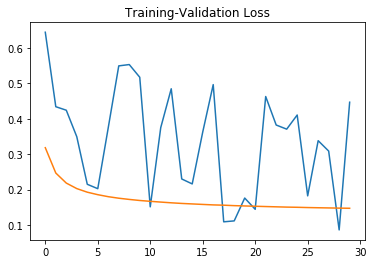

In [39]:
valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

epochs = 10
model = Model()
loss_func = F.cross_entropy
opt = optim.SGD(model.parameters(), lr=lr)

train_loss =[]
val_loss = []
for epoch in range(epochs):
    model.train()
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    train_loss.append(loss.item())
    model.eval() #call this to keep models like batchnorm and dropout 
    with torch.no_grad():
        valid = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)/(y_valid.shape[0]//bs)
        val_loss.append(valid.item())

plt.title("Training-Validation Loss")
plt.plot(range(len(train_loss)),train_loss) 
plt.plot(range(len(val_loss)),val_loss) 
plt.show()

### Create helper functions

[link](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [43]:
import numpy as np

def get_model():
    model = Model()
    return model, optim.SGD(model.parameters(), lr=lr, momentum=0.9)


def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)





def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3389158097743988
1 0.3067798109531403
2 0.29315096558332443
3 0.28442450717687606
4 0.2801130482196808
5 0.2775348304629326
6 0.27625955839157107
7 0.27282633156776426
8 0.2709454197406769
9 0.2699028342008591
10 0.2673029819011688
11 0.26685731422901154
12 0.26715501942634584
13 0.26514497152566907
14 0.2663704557955265
15 0.26351123942136767
16 0.26445348378419875
17 0.26294642906188964
18 0.26230059801340105
19 0.26210777661800383
20 0.2611381888628006
21 0.26052178966403006
22 0.26141355090141294
23 0.2642173074483872
24 0.26045167765021326
25 0.2590922660529614
26 0.26138583382368086
27 0.2592720721840858
28 0.26183348557949065
29 0.25875099403262136


### ConvNets

In [79]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16, kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))
    

In [80]:
model=CNN()
opt=optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.5522479145050049
1 0.3980927963256836
2 0.2782034362077713
3 0.21448879919052125
4 0.22370268186330794


### With Sequential

In [83]:
#create a custom layer

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [84]:
epochs = 5
lr=0.03
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.3)
fit(epochs,model,loss_func,opt,train_dl,valid_dl)

print(torch.argmax(model(x_train[:3]), dim=1))
print(y_train[:3])

0 0.6595972821235657
1 0.3279928419113159
2 0.2508931781232357
3 0.21666518794894218
4 0.27602433536946774
tensor([3, 0, 4])
tensor([5, 0, 4])


### Wrapping DataLoader

In [94]:
def preprocess(x, y): # the iterator gives X and y
    return x.view(-1,1,28,28), y

class WrappedDataLoader():
    """
    Create a custom iterator that processes your dataset.
    """
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    def __len__(self):
        return len(self.dl)
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
            
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)    

In [95]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), #adapts to the size of the image, outputs 1 dim
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)


0 0.9293505615234375
1 0.333184059882164
2 0.2696040114879608
3 0.2218672159910202
4 0.231476465600729


### Using your GPU

In [96]:
print(torch.cuda.is_available())

True


In [97]:
#create a device object to represent your GPU
dev = torch.device('cuda')

In [102]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1), #adapts to the size of the image, outputs 1 dim
    Lambda(lambda x: x.view(x.size(0), -1)),
)


def preprocess(x, y):
    return x.view(-1,1,28,28).to(dev), y.to(dev)

train_dl = DataLoader(train_ds,batch_size=bs,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model.to(dev)
opt = optim.SGD(model.parameters(),lr=0.03)
fit(10, model, loss_func, opt, train_dl, valid_dl)

0 2.2595356033325196
1 1.642110375213623
2 1.2932282413482665
3 0.8977149812698364
4 0.7996481155395507
5 0.8012100366592407
6 0.707154974269867
7 0.5995462689399719
8 0.7608398029327392
9 0.4844808643341064


### Closing thoughts
We now have a general data pipeline and training loop which you can use for training many types of models using Pytorch. To see how simple training a model can now be, take a look at the mnist_sample sample notebook.

Of course, there are many things you’ll want to add, such as data augmentation, hyperparameter tuning, monitoring training, transfer learning, and so forth. These features are available in the fastai library, which has been developed using the same design approach shown in this tutorial, providing a natural next step for practitioners looking to take their models further.

We promised at the start of this tutorial we’d explain through example each of torch.nn, torch.optim, Dataset, and DataLoader. So let’s summarize what we’ve seen:

torch.nn

Module: creates a callable which behaves like a function, but can also contain state(such as neural net layer weights). It knows what Parameter (s) it contains and can zero all their gradients, loop through them for weight updates, etc.

Parameter: a wrapper for a tensor that tells a Module that it has weights that need updating during backprop. Only tensors with the requires_grad attribute set are updated

functional: a module(usually imported into the F namespace by convention) which contains activation functions, loss functions, etc, as well as non-stateful versions of layers such as convolutional and linear layers.

torch.optim: Contains optimizers such as SGD, which update the weights of Parameter during the backward step

Dataset: An abstract interface of objects with a __len__ and a __getitem__, including classes provided with Pytorch such as TensorDataset

DataLoader: Takes any Dataset and creates an iterator which returns batches of data.

## Saving and Loading Modules
[link](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Three core functionalities
1. `torch.save` - serialize an object to disk using pickle.
2. `torch.load` - deserialize a file into an object
3. `torch.nn.Module.load_save_dict` -Model has a parameter dictionary, this loads that parameter dict with a deserialized state_dict.

### What is a `state dict`?
Parameters are stored and can be accessed `model.parameters()`. State_dict is a Python dictionary that maps each layer to its parameter tensor. Only layers with learnable parameters are present in the state_dict. `torch.optim` objects also have a `state_dict`


In [5]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16, 5)
        self.fc1 = nn.Linear(5*5*16,100)
        self.fc2 = nn.Linear(100,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

print("Model's state dict")
for param in model.state_dict():
    print(param, '\t', model.state_dict()[param].size())
print()

print("Optiimizer state dict")
for param in optimizer.state_dict():
    print(param, '\t', optimizer.state_dict()[param])

Model's state dict
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([100, 400])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([84, 100])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])

Optiimizer state dict
param_groups 	 [{'nesterov': False, 'weight_decay': 0, 'lr': 0.001, 'dampening': 0, 'momentum': 0.9, 'params': [1965805366008, 1965805478248, 1965805478320, 1965805478104, 1965805367016, 1965805478896, 1965805478752, 1965805478680, 1965805478464, 1965805478968]}]
state 	 {}


In [8]:
#print(model.state_dict()) dictionary with all parameters
print()
#print(model.parameters()) #python generator with 
start = True
for i in model.parameters():
    if start:
        print(i)
        start=False


Parameter containing:
tensor([[[[-0.0677,  0.0495, -0.1024, -0.0288,  0.0150],
          [ 0.0089,  0.0648, -0.0243, -0.1149, -0.0608],
          [-0.0073,  0.0856,  0.0961,  0.0575, -0.0908],
          [ 0.0819, -0.0539, -0.0713, -0.0717, -0.1135],
          [ 0.0187, -0.0606, -0.0438,  0.0182,  0.1140]],

         [[-0.0478,  0.0610,  0.1071,  0.0622,  0.0474],
          [-0.0730,  0.1031,  0.0523, -0.1106,  0.0753],
          [ 0.0329,  0.0756, -0.0991, -0.0225,  0.0712],
          [ 0.0546,  0.0377, -0.1027, -0.0913,  0.0827],
          [-0.1059,  0.1057,  0.0868,  0.0855, -0.0582]],

         [[ 0.0763, -0.0679, -0.0913,  0.0349,  0.0207],
          [-0.0685, -0.0617,  0.0178,  0.0948,  0.0173],
          [-0.0272, -0.0427, -0.0233, -0.0380,  0.1089],
          [ 0.0600, -0.0861,  0.0348, -0.0092, -0.0611],
          [-0.0331,  0.0114, -0.0381,  0.1013,  0.0244]]],


        [[[-0.0183,  0.0002,  0.0252,  0.0493,  0.1008],
          [ 0.1019,  0.1145,  0.0533, -0.0264, -0.0061],


### Saving a model for inference
Remember that you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.



In [9]:
torch.save(model.state_dict(), 'model_state_dict.pkl')
taco = Model()

#takes dictionary object
taco.load_state_dict(torch.load('model_state_dict.pkl'))
taco.eval()   #ets the module in evaluation mode.

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### save load entire model
This save/load process uses the most intuitive syntax and involves the least amount of code. Saving a model in this way will save the entire module using Python’s pickle module. The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved. The reason for this is because pickle does not save the model class itself. Rather, __it saves a path to the file containing the class, which is used during load time. Because of this, your code can break__ in various ways when used in other projects or after refactors.

In [ ]:
torch.save(model, PATH)
# Model class must be defined somewhere
model = torch.load(PATH)
model.eval()

### Saving a general checkpoint for inference and testing

In [ ]:
PATH='model_state_dict.pkl'

state = {
    'epoch':epoch+1,
    'state_dict':model.state_dict(),
    'optim_dict':optimizer.state_dict(),
}

torch.save(state, PATH)


model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# or
model.train()

### Saving Multiple Models in One File
When saving a model comprised of multiple torch.nn.Modules, such as a GAN, a sequence-to-sequence model, or an ensemble of models, you follow the same approach as when you are saving a general checkpoint. In other words, save a dictionary of each model’s state_dict and corresponding optimi

In [ ]:
torch.save({
            'modelA_state_dict': modelA.state_dict(),
            'modelB_state_dict': modelB.state_dict(),
            'optimizerA_state_dict': optimizerA.state_dict(),
            'optimizerB_state_dict': optimizerB.state_dict(),
            ...
            }, PATH)

checkpoint = torch.load(PATH)
modelA.load_state_dict(checkpoint['modelA_state_dict'])
modelB.load_state_dict(checkpoint['modelB_state_dict'])
optimizerA.load_state_dict(checkpoint['optimizerA_state_dict'])
optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

modelA.eval()
modelB.eval()
# - or -
modelA.train()
modelB.train()

### Warmstarting with params from a trained model

Whether you are loading from a partial state_dict, which is missing some keys, or loading a state_dict with more keys than the model that you are loading into, you can set the strict argument to False in the `load_state_dict()` function to ignore non-matching keys.

If you want to load parameters from one layer to another, but some keys do not match, simply change the name of the parameter keys in the state_dict that you are loading to match the keys in the model that you are loading into.

In [ ]:
torch.save(modelA.state_dict(), PATH)


modelB = TheModelBClass(*args, **kwargs)
modelB.load_state_dict(torch.load(PATH), strict=False)

### Save on GPU, Load on GPU

When loading a model on a GPU that was trained and saved on GPU, simply convert the initialized model to a CUDA optimized model using `model.to(torch.device('cuda'))`. Also, be sure to use the `.to(torch.device('cuda'))` function __on all model inputs__ to prepare the data for the model. Note that calling `my_tensor.to(device)` __returns a new copy of my_tensor on GPU__. It does NOT overwrite my_tensor. __Therefore, remember to manually overwrite tensors__: `my_tensor = my_tensor.to(torch.device('cuda'))`.

In [ ]:
#SAVE
torch.save(model.state_dict(), PATH)


#LOAD
device = torch.device('cuda')
model = Model()
model.load_state_dict(torch.load(PATH))
model.to(device)

In [ ]:
utils.save_checkpoint(state,
                     isbest=True,
                     checkpoint='filepath')
utils.load_checkpoint(restore_path, 
                      model, 
                      optimizer)

# Functions

### Convolutions

In [8]:
m = nn.Conv2d(16,33,(3,5), 
              stride=(2,1), 
              padding = (4,2), 
              dilation=(3,1))
input = Variable(torch.randn(20,16,50,100))
print(input.shape)
m(input).shape

torch.Size([20, 16, 50, 100])


torch.Size([20, 33, 26, 100])

### Pooling

In [28]:
"""
Max Pooling - cuts the size in have by retaining only the max 
value in a subset of a matrix. Outputs a smaller matrix with
the combined max values for the subcells.

Reduces the number of parameters to learn and provides basic 
 translation invariance to the internal representation.
"""
m = nn.MaxPool2d((2,2))
x = torch.arange(16, dtype = torch.float64).reshape(-1,4).unsqueeze(0)
pooled= m(x)
_print(x)
_print(pooled)

tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]], dtype=torch.float64) torch.Size([1, 4, 4]) 

tensor([[[ 5.,  7.],
         [13., 15.]]], dtype=torch.float64) torch.Size([1, 2, 2]) 



In [29]:
m = nn.AvgPool2d(2)
_print(m(x))

tensor([[[ 2.5000,  4.5000],
         [10.5000, 12.5000]]], dtype=torch.float64) torch.Size([1, 2, 2]) 



## Non-Linear Activation

In [40]:
x = Variable(torch.randn(3,3))
_print(x)

tensor([[-0.6745,  0.9691,  1.0134],
        [-0.3971,  0.3070, -0.0195],
        [ 0.0943, -0.8966,  0.7574]]) torch.Size([3, 3]) 



In [41]:
m = nn.ReLU()
_print(m(x))

tensor([[0.0000, 0.9691, 1.0134],
        [0.0000, 0.3070, 0.0000],
        [0.0943, 0.0000, 0.7574]]) torch.Size([3, 3]) 



In [42]:
m = nn.LeakyReLU()
_print(m(x))

tensor([[-6.7450e-03,  9.6910e-01,  1.0134e+00],
        [-3.9710e-03,  3.0700e-01, -1.9512e-04],
        [ 9.4303e-02, -8.9660e-03,  7.5740e-01]]) torch.Size([3, 3]) 



In [43]:
m = nn.Sigmoid()
_print(m(x))

tensor([[0.3375, 0.7249, 0.7337],
        [0.4020, 0.5762, 0.4951],
        [0.5236, 0.2897, 0.6808]]) torch.Size([3, 3]) 



In [48]:
m = nn.Softmax(dim=0)
_print(m(x))

tensor([[0.2234, 0.5986, 0.4695],
        [0.2948, 0.3087, 0.1671],
        [0.4819, 0.0927, 0.3634]]) torch.Size([3, 3]) 



## Normalization

In [ ]:
"""
nn.BatchNorm1d(
    num_features,
    eps=1e-05,
    momentum=0.1,
    affine=True,
    track_running_stats=True,
)
Docstring:     
Applies Batch Normalization over a 2D or 3D input (a mini-batch of 1D
inputs with optional additional channel dimension) as described in the paper
`Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift`_ .
"""

nn.BatchNorm1d(100)

## Recurrent Layers

In [53]:
    
"""
Applies a multi-layer Elman RNN with :math:`tanh` or :math:`ReLU` non-linearity to an
input sequence.


For each element in the input sequence, each layer computes the following
function:

.. math::
    h_t = \text{tanh}(W_{ih} x_t + b_{ih} + W_{hh} h_{(t-1)} + b_{hh})

where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is
the input at time `t`, and :math:`h_{(t-1)}` is the hidden state of the
previous layer at time `t-1` or the initial hidden state at time `0`.
If :attr:`nonlinearity` is ``'relu'``, then `ReLU` is used instead of `tanh`.

Args:
    input_size: The number of expected features in the input `x`
    hidden_size: The number of features in the hidden state `h`
    num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
        would mean stacking two RNNs together to form a `stacked RNN`,
        with the second RNN taking in outputs of the first RNN and
        computing the final results. Default: 1
    nonlinearity: The non-linearity to use. Can be either ``'tanh'`` or ``'relu'``. Default: ``'tanh'``
    bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
        Default: ``True``
    batch_first: If ``True``, then the input and output tensors are provided
        as `(batch, seq, feature)`. Default: ``False``
    dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
        RNN layer except the last layer, with dropout probability equal to
        :attr:`dropout`. Default: 0
    bidirectional: If ``True``, becomes a bidirectional RNN. Default: ``False``

Inputs: input, h_0
    - **input** of shape `(seq_len, batch, input_size)`: tensor containing the features
      of the input sequence. The input can also be a packed variable length
      sequence. See :func:`torch.nn.utils.rnn.pack_padded_sequence`
      or :func:`torch.nn.utils.rnn.pack_sequence`
      for details.
    - **h_0** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the initial hidden state for each element in the batch.
      Defaults to zero if not provided. If the RNN is bidirectional,
      num_directions should be 2, else it should be 1.

Outputs: output, h_n
    - **output** of shape `(seq_len, batch, num_directions * hidden_size)`: tensor
      containing the output features (`h_t`) from the last layer of the RNN,
      for each `t`.  If a :class:`torch.nn.utils.rnn.PackedSequence` has
      been given as the input, the output will also be a packed sequence.

      For the unpacked case, the directions can be separated
      using ``output.view(seq_len, batch, num_directions, hidden_size)``,
      with forward and backward being direction `0` and `1` respectively.
      Similarly, the directions can be separated in the packed case.
    - **h_n** of shape `(num_layers * num_directions, batch, hidden_size)`: tensor
      containing the hidden state for `t = seq_len`.

      Like *output*, the layers can be separated using
      ``h_n.view(num_layers, num_directions, batch, hidden_size)``.

Shape:
    - Input1: :math:`(L, N, H_{in})` tensor containing input features where
      :math:`H_{in}=\text{input\_size}` and `L` represents a sequence length.
    - Input2: :math:`(S, N, H_{out})` tensor
      containing the initial hidden state for each element in the batch.
      :math:`H_{out}=\text{hidden\_size}`
      Defaults to zero if not provided. where :math:`S=\text{num\_layers} * \text{num\_directions}`
      If the RNN is bidirectional, num_directions should be 2, else it should be 1.
    - Output1: :math:`(L, N, H_{all})` where :math:`H_{all}=\text{num\_directions} * \text{hidden\_size}`
    - Output2: :math:`(S, N, H_{out})` tensor containing the next hidden state
      for each element in the batch

Attributes:
    weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
        of shape `(hidden_size, input_size)` for `k = 0`. Otherwise, the shape is
        `(hidden_size, num_directions * hidden_size)`
    weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
        of shape `(hidden_size, hidden_size)`
    bias_ih_l[k]: the learnable input-hidden bias of the k-th layer,
        of shape `(hidden_size)`
    bias_hh_l[k]: the learnable hidden-hidden bias of the k-th layer,
        of shape `(hidden_size)`

.. note::
    All the weights and biases are initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`
    where :math:`k = \frac{1}{\text{hidden\_size}}`

.. include:: cudnn_persistent_rnn.rst

Examples::

    >>> rnn = nn.RNN(10, 20, 2)
    >>> input = torch.randn(5, 3, 10)
    >>> h0 = torch.randn(2, 3, 20)
    >>> output, hn = rnn(input, h0)
"""
#nn.RNN(input_size, hidden_size, num_recurrent_layers, nonlinearity,)
x = Variable(torch.randn(5,3,10))
rnn = nn.RNN(10,20,2)
h0 = Variable(torch.randn(2,3,20))
out, hn = rnn(x, h0)
print(out.shape)

torch.Size([5, 3, 20])


In [52]:
lstm = nn.LSTM(10,20,2)
c0 = Variable(torch.randn(2,3,20))
out, hn = lstm(x,(h0,c0))
print(out.shape)

torch.Size([5, 3, 20])


In [55]:
gru = nn.GRU(10,20,2)
out,hnn = gru(x, h0)
print(out.shape)

torch.Size([5, 3, 20])


## Linear

In [56]:
"""
nn.Linear(in_features, out_features, bias=True)
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

Args:
    in_features: size of each input sample
    out_features: size of each output sample
"""
x = Variable(torch.randn(128,20))
m = nn.Linear(20,2)
print(m(x).shape)

torch.Size([128, 2])


## Dropout

In [72]:
#zeroes out some of the values in the input tensor
m = nn.Dropout(p=0.5)
input = Variable(torch.randn(5, 2))
output = m(input)
output

tensor([[-0.0000, -0.0000],
        [-1.4435, -0.1157],
        [ 0.0000, -2.5524],
        [ 0.0000, -0.0000],
        [ 2.6681, -1.1160]])

## Embedding

In [73]:
# the input is an integer that selects the embedding
embedding = nn.Embedding(10,3)
x = torch.tensor([[2,1,1],[3,5,2]], dtype = torch.long)
embedding(x)

tensor([[[-1.0281, -0.1043, -0.9801],
         [ 0.0454,  1.2075, -0.5769],
         [ 0.0454,  1.2075, -0.5769]],

        [[ 0.7194,  1.8701, -0.5869],
         [ 0.8274,  0.9918,  0.6741],
         [-1.0281, -0.1043, -0.9801]]], grad_fn=<EmbeddingBackward>)

## Cosine Similarity

In [75]:
input1 = Variable(torch.randn(100, 128))
input2 = Variable(torch.randn(100, 128))
cos = nn.CosineSimilarity()
print(cos(input1,input2).shape)

torch.Size([100])


## Loss Functions

In [81]:
loss = nn.L1Loss()
pred = Variable(torch.randn(1,10), requires_grad=True)
target = Variable(torch.randn(1,10))
print(loss(pred,target))

tensor(1.1297, grad_fn=<L1LossBackward>)


In [82]:
loss = nn.MSELoss()
print(loss(pred,target))

tensor(1.8602, grad_fn=<MseLossBackward>)


In [95]:
loss = nn.CrossEntropyLoss()
target = Variable(torch.LongTensor(1).random_(5))
target = Variable(torch.randint(5, (1,),dtype=torch.long))
print(loss(pred,target))

tensor(1.7376, grad_fn=<NllLossBackward>)


In [93]:
target

tensor([4])

## init

In [97]:
w = torch.empty(3,5)
nn.init.normal(w) #operates inplace

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  


tensor([[-1.1021, -2.0721, -1.0736, -0.4213,  1.4890],
        [-0.1656, -0.0502, -1.2592, -0.7588, -0.2377],
        [ 0.2969,  0.1076,  0.6622,  0.1856, -0.0085]])